# 02 Machine Learning / Proyecto

## Credit Card Leads

### Equipo:
- Javier De La Rosa Mondragon
- Luis Fernando Merino Nambo
- Salomon Ramírez

![Leads](credit-cards.jpg)

##  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 filas en train set

- ~100,000 etiquetas en test set

- 10 Features
    - ID
    - Sexo
    - Edad
    - Region
    - Ocupación
    - Channel code
    - Vintage
    - Credit product
    - Balance promedio
    - Activo
    


- 1 Columna de target
    - Lead

## Objetivo

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features los datos del cliente y los productos con los que ya cuentan.


## Importación de bibliotecas 

In [1]:
# VARIABLES DE EJECUCIÓN
FINAL = False
NON_FINAL_DATA_FRACTION =.3
LONG_TIME_CELLS = False

In [45]:
# numerical y Dfs
import pandas as pd
import numpy as np

# ML:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # selección de features categoricas

# árboles de decisión y visualización
from sklearn.tree import DecisionTreeClassifier
#from dtreeviz import model
from dtreeviz.trees import *

# métricas de rendimiento
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score

# visualización
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# paletas
#palQualitative = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
palQualitative = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palPaired = sns.color_palette("Accent")
sns.set()
sns.set_palette( palQualitative )

## Lectura de datos

In [3]:
creditCardLeadDataFrame = pd.read_csv('./data/train data credit card.csv')

if FINAL:
    data = creditCardLeadDataFrame.copy()
else:
    creditCardLeadDataFrame = creditCardLeadDataFrame.sample(frac=NON_FINAL_DATA_FRACTION)
    creditCardLeadDataFrame.reset_index(inplace=True,drop=True)
    data = creditCardLeadDataFrame.copy()

print('Data size:',data.shape)

Data size: (73718, 11)


In [4]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,AQUKDCJO,Male,38,RG269,Self_Employed,X2,33,Yes,1100876,No,0
1,BXKL8XWV,Male,44,RG282,Other,X2,25,NaN,582932,No,1
2,K3DBPAFZ,Female,42,RG257,Self_Employed,X3,43,No,711688,Yes,0
3,F4DCTJVU,Female,29,RG270,Self_Employed,X1,26,No,360850,No,0
4,LPLQPXNE,Male,48,RG284,Self_Employed,X2,27,No,683012,Yes,0


## Limpieza y EDA

In [5]:
display(data.isna().sum())
print(data.shape)

ID                        0
Gender                    0
Age                       0
Region_Code               0
Occupation                0
Channel_Code              0
Vintage                   0
Credit_Product         8734
Avg_Account_Balance       0
Is_Active                 0
Is_Lead                   0
dtype: int64

(73718, 11)


In [6]:
# ya que el trainset es muy grande, empezaremos eliminando las filas con datos vaciós
data = data.dropna()
data.reset_index(inplace=True,drop=True)
display(data.isna().sum().sum())
print(data.shape)

0

(64984, 11)


In [7]:
# hagamos una copia del dataset "original" (luego de a limpieza de datos):
dataOriginal = data.copy()

In [8]:
def create_piechart_with_values(data, title, ax, optional_names=None):
    df = data
    value_counts = df.value_counts()
    category_counts = df.value_counts().values
    patches, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

    total = sum(value_counts.values)
    label_values = []
    if optional_names:
        value_counts.index = optional_names
        
    for n,v in zip(value_counts.index,value_counts.values):
        v = f'{v:,}'
        #label_values.append(    f'{n}: {v} ({(v / total) * 100:.1f}%)'    )
        label_values.append(    f'{n}: {v}'    )
    
    for i, text in enumerate(texts):
        text.set_text(label_values[i])
    
    ax.set_title(title)

### Variables Categóricas

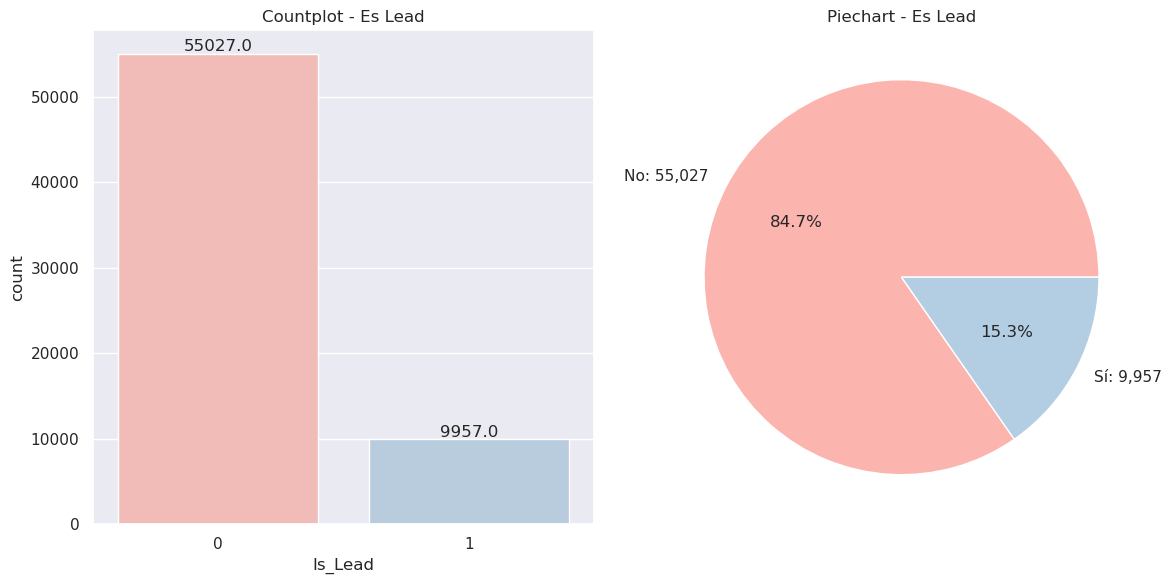

In [9]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x=data.Is_Lead, ax=ax1)
ax1.set_title('Countplot - Es Lead')

for p in ax1.patches:
    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

create_piechart_with_values(data.Is_Lead, 'Piechart - Es Lead',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()


In [10]:
# Observamos que hay una deproporción muy grande.

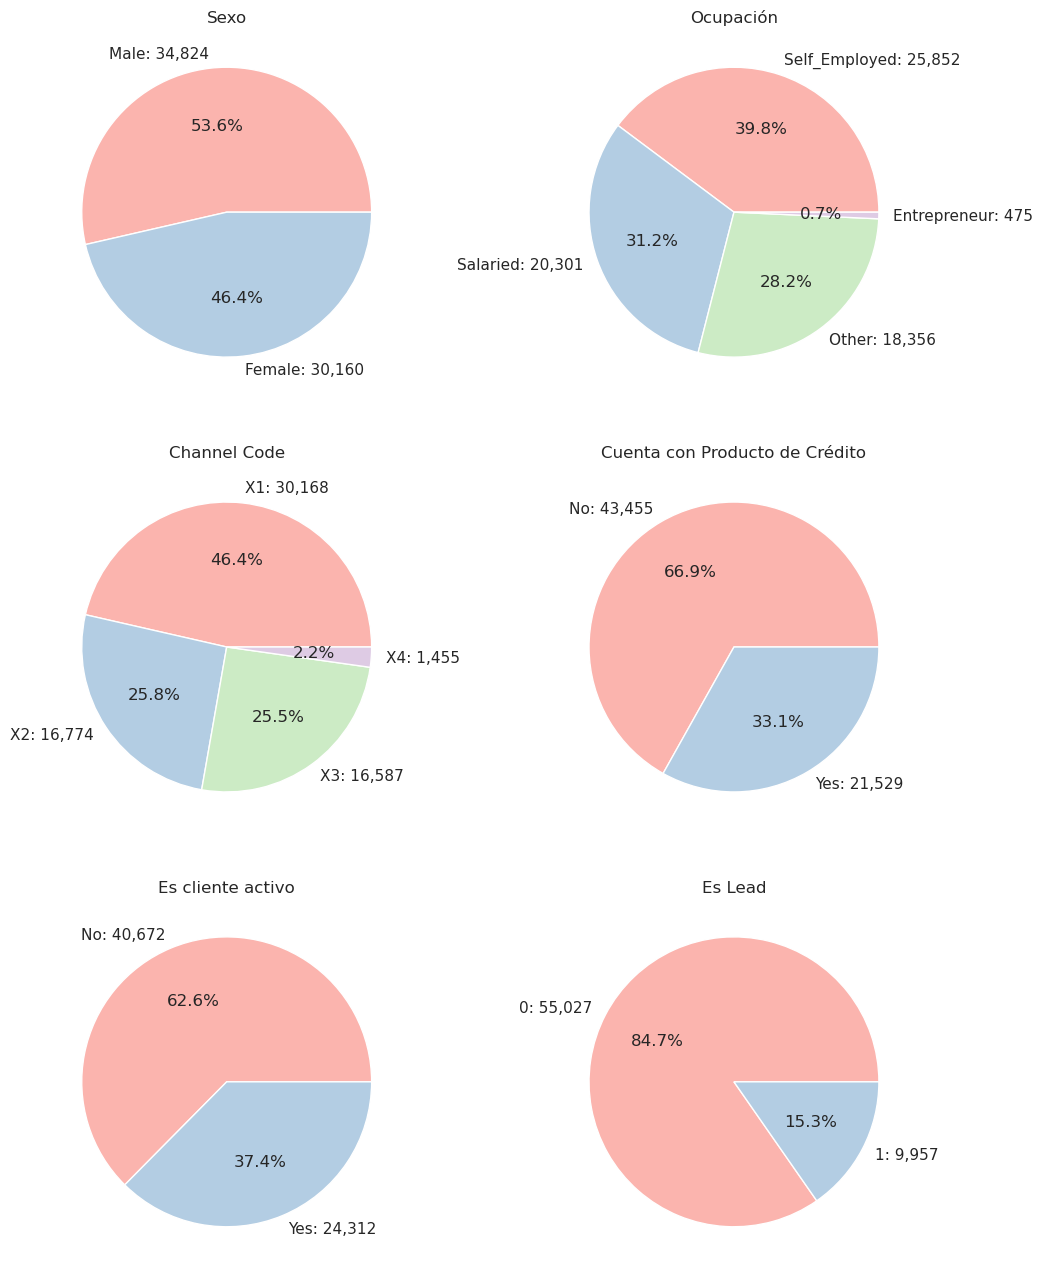

In [11]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

#sns.countplot(data=creditCardLeadDf, x='Gender', ax=axes[0])
#axes[0].set_title('Sexo')
#sns.countplot(data=creditCardLeadDf, x='Is_Active', ax=axes[0])
#axes[0].set_title('Es cliente activo')
#sns.countplot(data=creditCardLeadDf, x='Credit_Product', ax=axes[1])
#axes[1].set_title('Cuenta con Producto de Crédito')
#sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes[1])
#axes[1].set_title('Ocupación')

create_piechart_with_values(data.Gender, 'Sexo',axes[0][0])
create_piechart_with_values(data.Occupation, 'Ocupación',axes[0][1])
create_piechart_with_values(data.Channel_Code, 'Channel Code',axes[1][0])
create_piechart_with_values(data.Credit_Product, 'Cuenta con Producto de Crédito',axes[1][1])
create_piechart_with_values(data.Is_Active, 'Es cliente activo',axes[2][0])
create_piechart_with_values(data.Is_Lead, 'Es Lead',axes[2][1])

#plt.tight_layout()
plt.show()

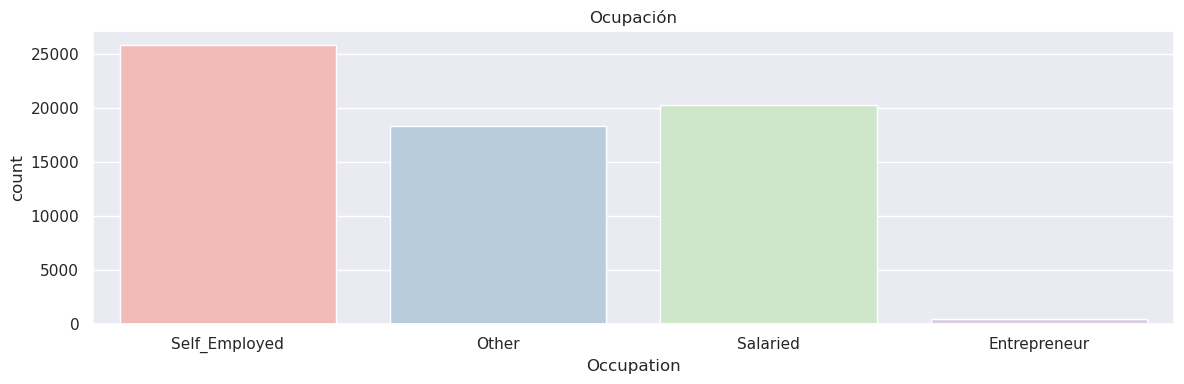

In [12]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data, x='Occupation', ax=axes)
axes.set_title('Ocupación')
plt.tight_layout()

# Show the plot
plt.show()

Hay 35 valores distintos de Region_Code


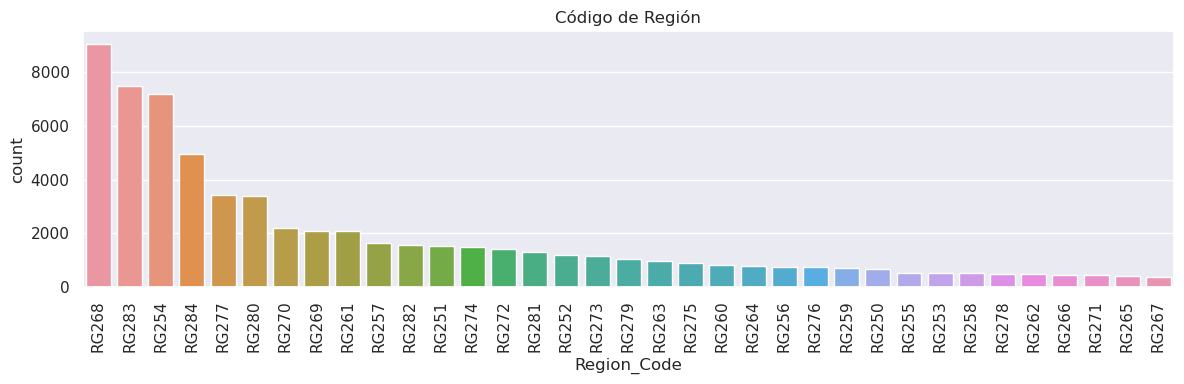

In [13]:
# Veamos las proporciones en algunas variables:
print('Hay',data.Region_Code.value_counts().shape[0],'valores distintos de Region_Code')

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data.sort_values(by='Region_Code'), x='Region_Code', ax=axes, order = data['Region_Code'].value_counts().index)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_title('Código de Región')
plt.tight_layout()

# Show the plot
plt.show()

Veremos más adelante si esta variable es relevante para la clasificación


### Variables Numéricas

Veamos histogramas y boxplots para las dos variables numéricas que tienen nuestros datos

In [14]:
def createHist(data,titulo,nobins=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 4))
    #data = creditCardLeadDf['Avg_Account_Balance']
    #titulo = 'Balance Promedio'

    if nobins:
        sns.histplot(data,ax=axes[0],bins= (data.max()-data.min()) )
    else:
        sns.histplot(data,ax=axes[0] )
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(titulo+' - Histograma')

    sns.boxplot(x=data, ax=axes[1])
    mean_value = np.mean(data)
    axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
    axes[1].text(mean_value+mean_value/1.5, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
    #axes[1].set_xlabel('Values')
    #axes[1].set_ylabel('Count')
    axes[1].set_title(titulo+' - Boxplot')
    #axes[1].legend()


    plt.tight_layout()
    plt.show()


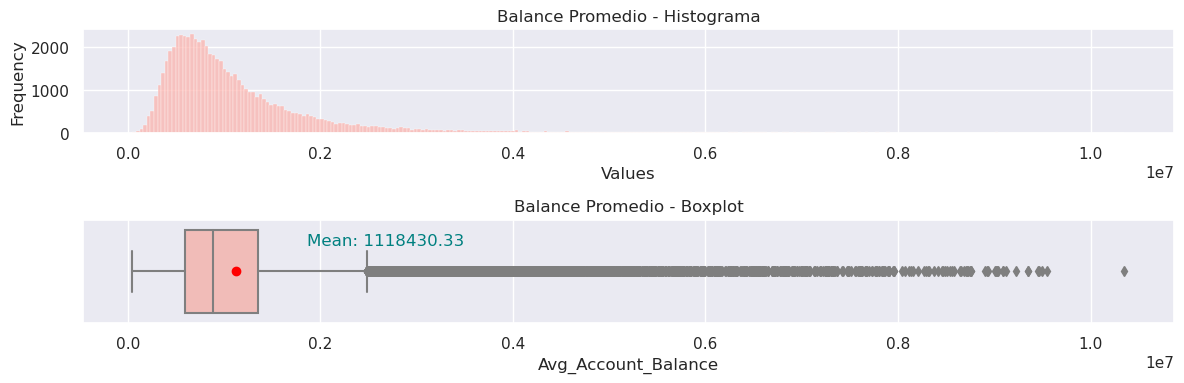

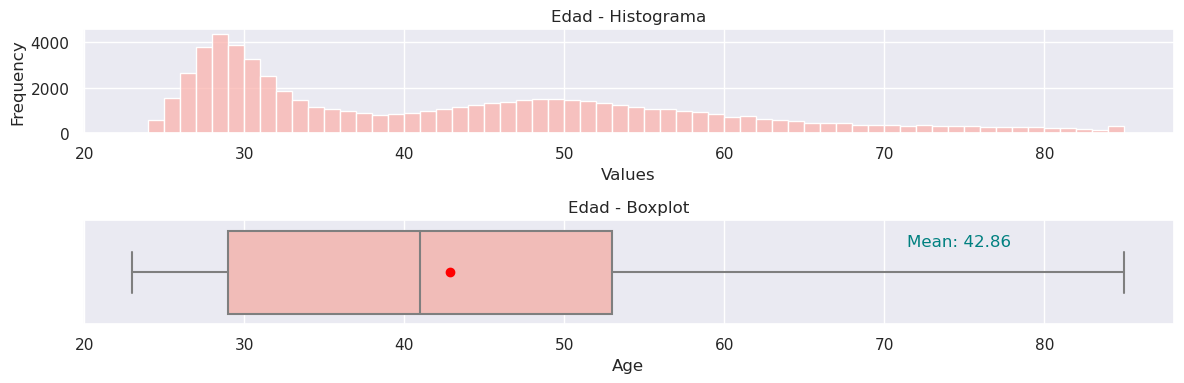

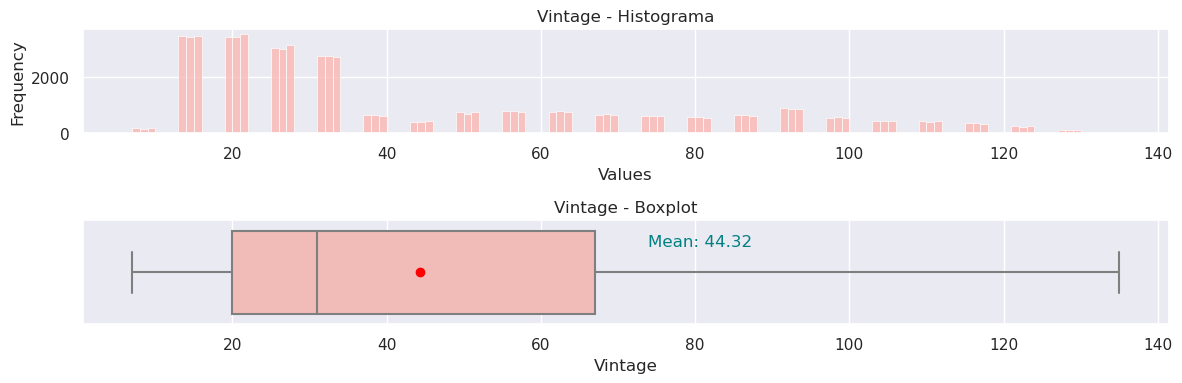

In [15]:
#sns.set_palette( palQualitative )
createHist(data['Avg_Account_Balance'],'Balance Promedio')
createHist(data['Age'],'Edad',nobins=True)
createHist(data['Vintage'],'Vintage',nobins=True)

In [16]:
# ya que la columna ID no aporta nada a la clasificación, la eliminaremos
data = data.drop('ID', axis=1)

In [17]:
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Male,38,RG269,Self_Employed,X2,33,Yes,1100876,No,0
1,Female,42,RG257,Self_Employed,X3,43,No,711688,Yes,0
2,Female,29,RG270,Self_Employed,X1,26,No,360850,No,0
3,Male,48,RG284,Self_Employed,X2,27,No,683012,Yes,0
4,Female,54,RG280,Self_Employed,X3,110,No,557674,Yes,1


### Conversión de variables a one-hot encoding

In [18]:
# las siguientes columnas puedes ser codificadas como one-hot:
# Gender (2 valores), Region_Code (35), Occupation (4), Channel_Code (4), Credit_Product (2), Is_Active (2)

In [19]:
# Codificamos en one-hot:
toOneHot = ['Gender', 'Occupation', 'Is_Active', 'Credit_Product','Channel_Code', 'Region_Code']
data = pd.get_dummies(data,columns=toOneHot)
print(data.shape)
display(data)

(64984, 53)


,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284
0,38,33,1100876,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,42,43,711688,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,29,26,360850,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,48,27,683012,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,54,110,557674,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64979,64,87,841192,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64980,38,27,1043275,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
64981,36,61,769903,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64982,54,74,1543438,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [20]:
# Para las variables que originalmente eran binarias, podemos eliminar una de sus
# dos columnas provenientes de get_dummies (Gender, Is_Active, ):
print(data.shape)
data = data.drop(['Gender_Female','Is_Active_No','Credit_Product_No'], axis=1)
print(data.shape)

(64984, 53)
(64984, 50)


In [21]:
# Tratemos de ver correlación entre las variables de Channel_Code y la salida
x_vars = [ x for x in list(data) if 'Channel_Code' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Channel-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Parece que por lo menos las tres primeras sí tienen un efecto en la salida
# Aquí podría parecer que el chanel X4 es el menos efectivo obteniendo leads

In [22]:
# Tratemos de ver correlación entre las variables de Occupation y la salida
x_vars = [ x for x in list(data) if 'Occupation' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Ocupación-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Vemos que de entre las 4, Occupation_Entrepreneur es la que tiene más efecto sobre la salida

In [23]:
# Tratemos de ver correlación entre nuestras variables numéricas y la salida:
x_vars = ['Age','Avg_Account_Balance','Vintage'] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Variables Numéricas-Salida', y=1.08)
    plt.show()
    
# Observaciones:
# Vemos que de las tres tienen cierto grado apreciable de correlación con la salida

In [24]:
# Y ahora veamos la correclación entre esas tres variables
#sns.pairplot(data, vars=x_vars, hue='Is_Lead', markers = ['d','v'], kind = "hist", diag_kind = None)
if LONG_TIME_CELLS:
    sns.pairplot(data, vars=x_vars, hue='Is_Lead', kind = "hist", diag_kind = 'kde')

# Observaciones:
# No encotramos mucha correlación entre éstas

In [25]:
# También vemos la correlación entre estas variables usando Spearman
display(data[x_vars].corr(method="spearman"))

# Observaciones:
# Se observa una correlación significativa entre Age y Vintage, lo cual es de esperarse porque
# sólo la gente de mayor edad puede tener más historial crediticio
# (Yo esperaba encontrar más correlación entre edad y balance)

,Age,Avg_Account_Balance,Vintage
Age,1.000000,0.166148,0.653967
Avg_Account_Balance,0.166148,1.000000,0.179172
Vintage,0.653967,0.179172,1.000000


In [26]:
# Tratemos de ver correlaciones entre las variables de región y la salida
x_vars = list(data)
x_vars = [ x for x in x_vars if 'Region' in x] 

#print(x_vars)
#print(len(x_vars))

graphsPerRow = 5

assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'

if LONG_TIME_CELLS:
    for i in range(int(len(x_vars)/graphsPerRow)):
        sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        plt.show()

# Observaciones:
# No notamos que alguna región destaque

In [27]:
# Veamos si hay otras correlaciones entre nuestras variables:
thres = .4
corrs = data.corr(method="spearman")
print(f'Spearman > {thres}:')
print(f'-------------------------')
moreCorr = []
for i, row in corrs.iterrows():
    for ic,val in zip(list(data),row):
        if val>thres and i!=ic:
            if val>=.4 and val<.69:
                note = 'Moderate Correlation'
            elif val>.7 and val<.89:
                note = 'Strong Correlation'
            elif val>=.9:
                note = 'Very Strong Correlation'
                
            variablesCorrelacionadas = [i,ic]
            variablesCorrelacionadas.sort()
            text = ' - '.join(variablesCorrelacionadas)
            moreCorr.append(f' {text} : {str(round(val,3))} ({note})')

moreCorr=list(set(moreCorr))
moreCorr.sort()
for i in moreCorr:
    print(i)

Spearman > 0.4:
-------------------------
 Age - Channel_Code_X3 : 0.475 (Moderate Correlation)
 Age - Vintage : 0.654 (Moderate Correlation)
 Channel_Code_X1 - Occupation_Salaried : 0.605 (Moderate Correlation)
 Channel_Code_X3 - Vintage : 0.487 (Moderate Correlation)


### Observaciones:
Se nota una correlación moderada entre Channel_Code_X3 y  Vintage (pudo ser que ese canal se enfocó en ciertos clientes con mucha o poca antiguedad).

También moderada de ese mismo canal y la edad de los clientes.

Y correlaciones un poco más fuertes entre el canal X1 y clientes asalariados.

Desde luego, la correlación que ya habiamos notado entre edad y vintage (historial crediticio).

### Primer Splitting

In [28]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

## Selección de features

In [29]:
# Selección de Features con Threshold fue descartada debido al alto número de variables categpóicas
best=10
selector = SelectKBest(k=best,score_func=chi2)

#scaler = MinMaxScaler()
#XScaled = scaler.fit_transform(X)
#XScaled = pd.DataFrame(data=XScaled, columns=list(X))

selector.fit(X,y)
print(f'Las {best} mejores features son:')
for col in selector.get_feature_names_out():
    print(f'   {col}')


Las 10 mejores features son:
   Age
   Vintage
   Avg_Account_Balance
   Occupation_Entrepreneur
   Occupation_Salaried
   Is_Active_Yes
   Credit_Product_Yes
   Channel_Code_X1
   Channel_Code_X2
   Channel_Code_X3


**Observaciones:**

Las 3 variables numéricas son las más importantes de acuerdo al selector. También confirmamos que de las variables categóricas, Occupation_Entrepreneur juega el papel más importante importante.

### Arboles de decisión con datos originales

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [31]:
importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

,importancia
feature,
Avg_Account_Balance,0.276
Age,0.158
Vintage,0.152
Credit_Product_Yes,0.103
Occupation_Salaried,0.035
Gender_Male,0.024
Is_Active_Yes,0.024
Region_Code_RG268,0.017
Channel_Code_X3,0.014


Accuracy: 0.792
Recall: 0.35489
Precision: 0.323


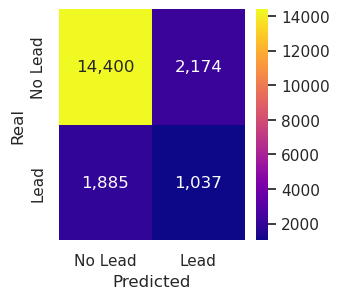

In [32]:
print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()

**Observaciones:**
    
Al parecer el hecho de que los ejemplos están desbalanceados affecta el modelo. A continuación balancearemos los ejemplos por medio de sub/over sampling.

### Re-sampling de datos de entrenamiento


### Árboles de decisión con datos submuestreados

In [33]:
import imblearn

#Submuestreo

# lista los índices de Is_Lead
lead_idxs = data[data["Is_Lead"]==1].index.to_list()
print('Is_Lead == 1: ',len(lead_idxs))

# lista de índices que no son lead
nolead_idxs = data[data["Is_Lead"]==0].index.to_list()
print('Is_Lead == 0: ',len(nolead_idxs))

# seleccionamos aleatoriamente el doble de índices de no leads
random_nolead_idxs = np.random.choice(nolead_idxs, int(len(lead_idxs)*1.5), replace= False)
print('random picks len:',len(random_nolead_idxs))

# concatenamos los índices fraudulentos y normales y creamos el dataframe sub-sampleado
undersampled_indices = np.concatenate([lead_idxs, random_nolead_idxs])
undersampled_data = data.iloc[undersampled_indices,:]

print(f"Lead: {len(lead_idxs)}, Normales: {len(random_nolead_idxs)}")

print(f'Tamaño de data sin resampling: {data.shape}')
print(f'Tamaño de data luego de resampling: {undersampled_data.shape}')

Is_Lead == 1:  9957
Is_Lead == 0:  55027
random picks len: 14935
Lead: 9957, Normales: 14935
Tamaño de data sin resampling: (64984, 50)
Tamaño de data luego de resampling: (24892, 50)


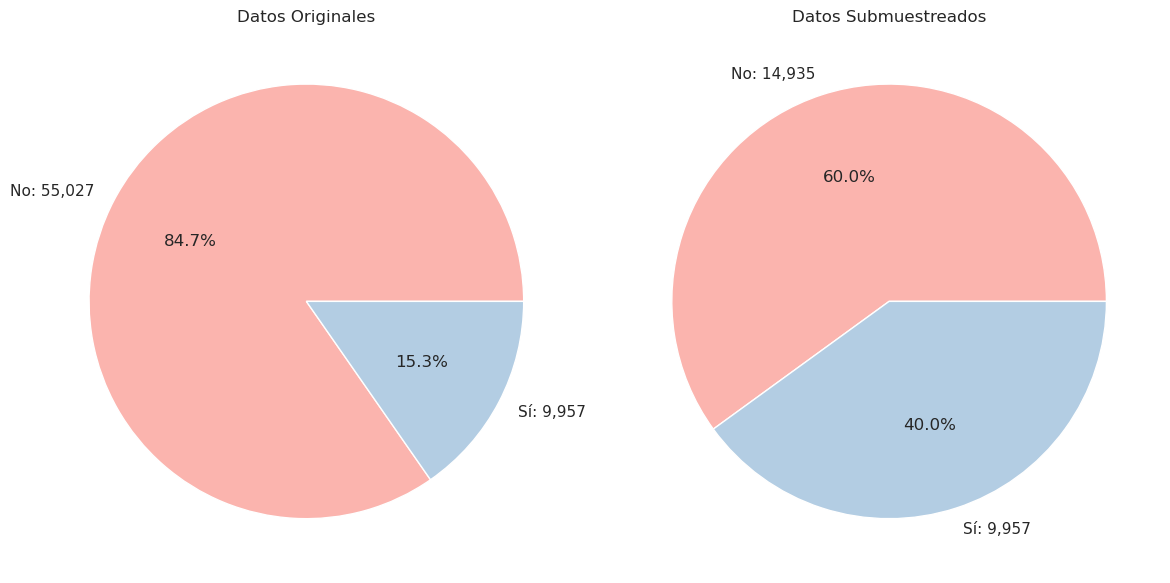

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

create_piechart_with_values(data.Is_Lead, 'Datos Originales',ax1,['No','Sí'])    
create_piechart_with_values(undersampled_data.Is_Lead, 'Datos Submuestreados',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()

In [35]:
# "backup de data"
dataBkup = data

,importancia
feature,
Avg_Account_Balance,0.232
Credit_Product_Yes,0.171
Age,0.150
Vintage,0.149
Gender_Male,0.025
Is_Active_Yes,0.025
Occupation_Salaried,0.022
Region_Code_RG268,0.017
Region_Code_RG283,0.014


Accuracy: 0.652
Recall: 0.57006
Precision: 0.57


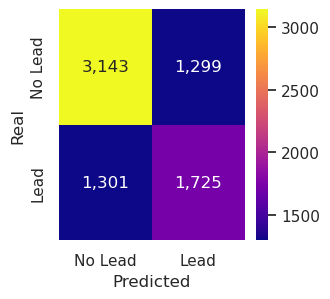

In [36]:
X = undersampled_data.drop('Is_Lead',axis=1)
y = undersampled_data['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



### Árboles de decisión con oversampling

In [37]:
from imblearn.over_sampling import SMOTE

# restauramos data
data=dataBkup
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

print(data.shape)

oversample = SMOTE()
X_oversampled, y_oversampled = oversample.fit_resample(X, y)

print(f"Matriz de features: {X_oversampled.shape}")
print(f"Matriz de etiquetas: {y_oversampled.shape}")

from collections import Counter
print(Counter(y_oversampled))

(64984, 50)
Matriz de features: (110054, 49)
Matriz de etiquetas: (110054,)
Counter({0: 55027, 1: 55027})


,importancia
feature,
Channel_Code_X1,0.229
Avg_Account_Balance,0.131
Occupation_Other,0.113
Occupation_Self_Employed,0.101
Vintage,0.085
Age,0.070
Channel_Code_X2,0.044
Channel_Code_X3,0.038
Is_Active_Yes,0.028


Accuracy: 0.855
Recall: 0.86847
Precision: 0.843


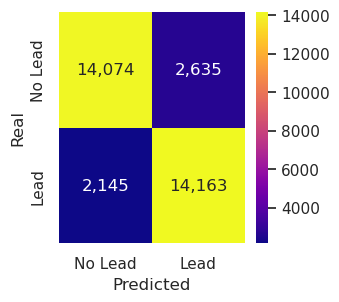

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



In [48]:
viz = model(clf,
        tree_index=3,
        X_train=X_train,
        y_train=y_train,
        feature_names=list(X_train),
        target_name='Lead',
        class_names=['Lead','No Lead']
)

if LONG_TIME_CELLS:
    pass
#viz_cmodel.view(scale=1.2,fontname='DejaVu Sans')
#viz_cmodel.view(scale=1.2,fontname='DejaVu Sans')

In [ ]:
viz.view(scale=1.2,fontname='DejaVu Sans')

## Búsqueda de componentes pricipales

In [ ]:
pca = PCA(n_components=11)
X_red = pca.fit_transform(X_scaled)
#X_challenge_red = pca.transform(X_challenge_scaled)

print('Train data luego de reducción de dimensionalidad:',X_red.shape)
#print('Test data luego de reducción de dimensionalidad:',X_challenge_red.shape)

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))

plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '-*',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")
print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{np.cumsum(pca.explained_variance_ratio_)}\n")

maxPC = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0]
plt.axhline(0.95,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
print(f"El 95% de la varianza se obtiene con {maxPC} componentes principales\n")

### clustering para ver los clientes parecidos